## Introduction

#### The goal of this analysis to to build a simple linear regression model that predicts the interst rate of any given loan application.

## Imports

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept, StandardScaler)
from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

## EDA

Looking at our data to start out, we can see that most of our attributes are formatted in what we would consider the proper format. The only one that I will choose to re-format is "interest_rate". From there, plotting a matrix of scatter plots will allows us to get a general overies of how each attribute is distributed, as well as how they vary together.

In [243]:
df = pd.read_csv("data/loansData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
interest_rate                 2498 non-null float64
fico_range                    2498 non-null object
amount_requested              2498 non-null float64
amount_funded_by_investors    2498 non-null float64
loan_length                   2498 non-null float64
dtypes: float64(4), object(1)
memory usage: 97.7+ KB


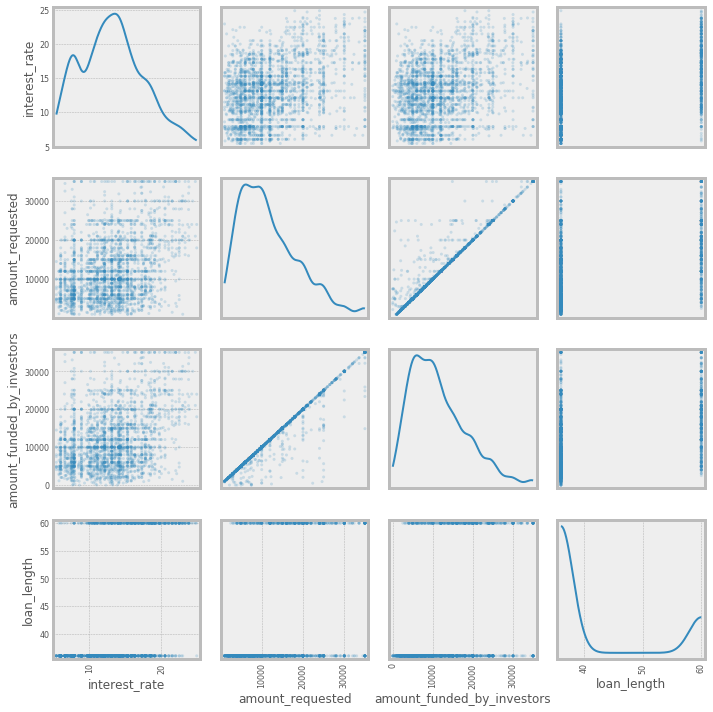

In [244]:
_ = scatter_matrix(df, alpha=0.2, figsize=(10,10), diagonal="kde")
plt.tight_layout()

Right off the bat we can see that the "amount_request" and the "amount_funded_by_investors" are highly correlated. To put a quantity on the correlation we find that..

In [245]:
amts_corr = df.corr().loc['amount_requested','amount_funded_by_investors']
print("The correlation between the 'amount_requested' and the 'amount_funded_by_investors' is: {0:.2f}".format(amts_corr))

The correlation between the 'amount_requested' and the 'amount_funded_by_investors' is: 0.97


Looking at the two plots below, this is confirmed visually in that if I create a linear model that predicts interest rate using each attribute with some cubic splines, you can hardly tell the difference between the two.

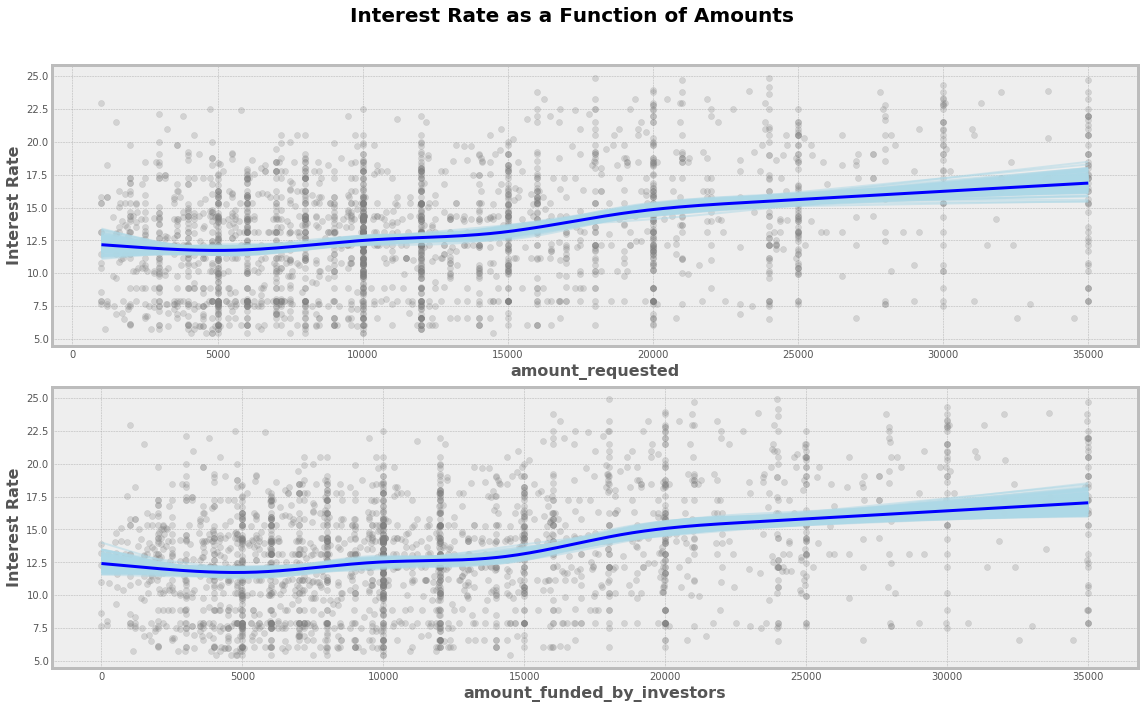

In [246]:
def plot_one_univariate(ax, var_name, mask=None):
    if mask is None:
        plot_univariate_smooth(
            ax,
            df[var_name].values.reshape(-1, 1),
            df['interest_rate'],
            bootstrap=200)
        ax.set_xlabel(var_name, fontweight="bold", fontsize=16)
        ax.set_ylabel("Interest Rate", fontweight="bold", fontsize=16)
        plt.tight_layout()
    else:
        plot_univariate_smooth(
            ax,
            df[var_name].values.reshape(-1, 1),
            df['interest_rate'],
            mask=mask,
            bootstrap=200)
        ax.set_xlabel(var_name, fontweight="bold", fontsize=16)
        ax.set_ylabel("Interest Rate", fontweight="bold", fontsize=16)
        plt.tight_layout()
    
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(2,1,1)   
plot_one_univariate(ax, "amount_requested")
ax1 = fig.add_subplot(2,1,2)
plot_one_univariate(ax1, "amount_funded_by_investors")
plt.suptitle("Interest Rate as a Function of Amounts", fontweight="bold", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

## Data Cleaning: Fico Scores

Looking back at our Fico Scores (below), we notice that there are 38 total groupings, and, if we look closely, that the mean interest rate seems to decline in a linear fashion as the Fico Range increases.

Knowing this, I came up with two possible courses of action:

* **Create Dummy Variables**: If I were to create 38 dummy variables, this would conceptually correspond to 38 different regression lines, where the slope of each line is the same, and they are spaced out by their respective coefficients. 

    $$y~=~\beta_{0}~+~\beta_{1}x_1~+~\beta_{2}x_2~+~\beta_{3}x_3~...~$$
    
      * There isn't anything wrong with this method, however, instead of having my model estimate 38 different coefficients, the 37 of which will be zero when testing any given new data point, I opted for the second option.
    
    
* **Make the Variable Continuous**: By changing the variable to a continuous attribute, we allow our model to only calculate one coefficient (as opposed to 38), not to mention it becomes much more interpretable.

In [247]:
df.groupby('fico_range').mean().shape

(38, 4)

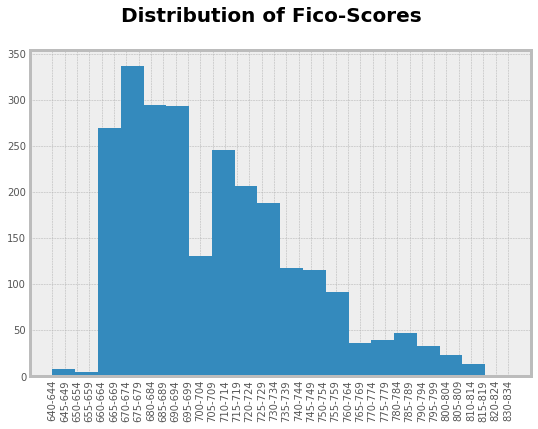

In [248]:
df.groupby('fico_range').mean().head()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(df['fico_range'], bins = 20)
plt.xticks(rotation=90)
plt.suptitle("Distribution of Fico-Scores", fontweight="bold", fontsize=20)
plt.show()

### Change Fico Scores to Continuous Variable

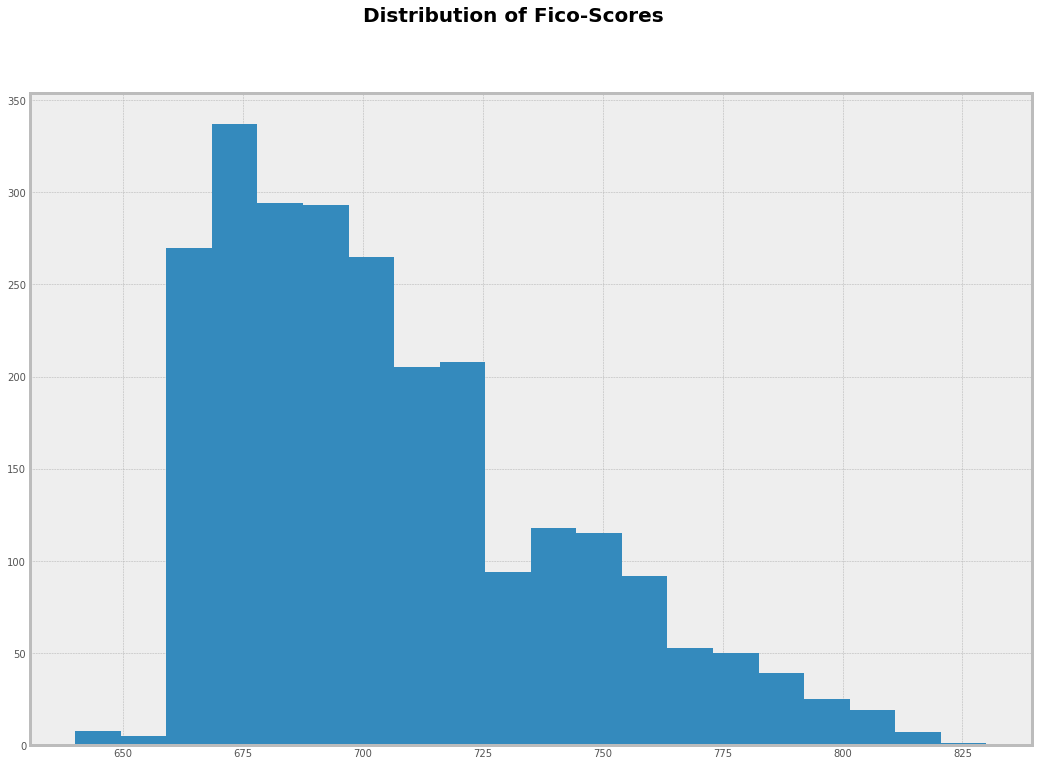

In [249]:
df['fico_start'] = df['fico_range'].map(lambda x: int(x[:3]))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.hist(df['fico_start'], bins = 20)
plt.suptitle("Distribution of Fico-Scores", fontweight="bold", fontsize=20)
plt.show()

Now that we have cleaned our data, we can plot the continuous Fico score against Inertest Rate...

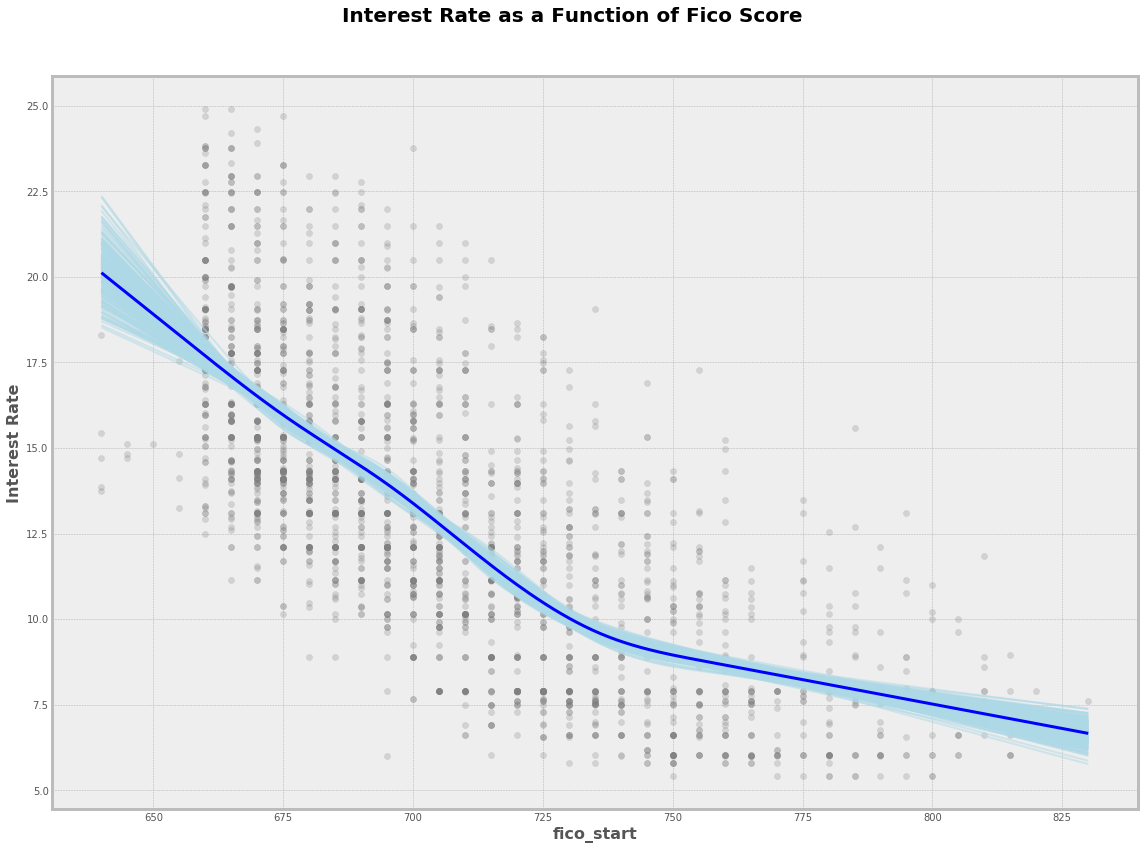

In [260]:
fig, ax = plt.subplots(figsize=(16, 12)) 
plot_one_univariate(ax, "fico_start")
plt.suptitle("Interest Rate as a Function of Fico Score", fontweight="bold", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.show()

As we can see, our adjusted data predicts Interets Rate's fairly well, the bootstapped confidence interval being relatively narrow throughout the middle of the plot. To ensure that this new variable isn't correlated with Amount Requested, we calculate the correlation between the two below. Since their correlation is very close to zero, we shouldn't run into any problems with the two variables I plan on using to model our Interest Rate.

In [271]:
print("The correlation between Fico Score and Amount Requested is: {0:.2f}".format(df.corr().loc['fico_start','amount_requested']))

The correlation between Fico Score and Amount Requested is: 0.08


## Pipelines

Now that I know that I want use the "Amount Requested" and the continuous Fico Score as my two predictors, I create two Pipelines (one for each predictor) that adds a Cubic spline to both predictors. Finally, I used a Feature Union to transform each of the predictors and then bring them together in one final data frame.

In [280]:
fico_pipe = Pipeline([
    ('select_fico', ColumnSelector(name="fico_start")),
    ('cubic_spline', NaturalCubicSpline(knots=[620,690,725,740,775]))
])

requested_pipe = Pipeline([
    ('select_amt_req', ColumnSelector(name="amount_requested")),
    ("amt_req_cub_spline", NaturalCubicSpline(knots=[5000,10000,14000,20000,25000]))
])

features_pipe = FeatureUnion([
    ('intercept', Intercept()),
    ('amt_req_pipe', requested_pipe),
    ('fico_pipe', fico_pipe)
])

features_pipe.fit(df)
features = features_pipe.transform(df)
features.head()
adjusted_loan_data = pd.concat([features, df['interest_rate']], axis=1)
adjusted_loan_data.head()

,intercept,amount_requested_spline_linear,amount_requested_spline_0,amount_requested_spline_1,amount_requested_spline_2,fico_start_spline_linear,fico_start_spline_0,fico_start_spline_1,fico_start_spline_2,interest_rate
0,1.0,20000.0,168750000.0,6.666667e+07,1.963636e+07,735.0,9812.096774,1072.058824,20.0,8.90
1,1.0,19200.0,143164400.0,5.191253e+07,1.278255e+07,715.0,5531.451613,183.823529,0.0,12.12
2,1.0,35000.0,825000000.0,5.000000e+08,2.760000e+08,690.0,2212.903226,0.000000,0.0,21.98
3,1.0,10000.0,6250000.0,0.000000e+00,0.000000e+00,695.0,2721.774194,1.470588,0.0,9.99
4,1.0,12000.0,17150000.0,5.333333e+05,0.000000e+00,695.0,2721.774194,1.470588,0.0,11.71


## Model

In [286]:
lm = LinearRegression(fit_intercept=False)
response = df.iloc[:, 0]
lm.fit(features.values, response)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [287]:
display_coef(lm, features.columns)

Name                               Parameter Estimate  
-------------------------------------------------------
intercept                          91.32562747363562   
amount_requested_spline_linear     9.815406437898116e-05
amount_requested_spline_0          1.881980704889169e-08
amount_requested_spline_1          -9.639578640936361e-09
amount_requested_spline_2          -2.7288377528743605e-08
fico_start_spline_linear           -0.1139674782708736 
fico_start_spline_0                -0.00010274509342773818
fico_start_spline_1                0.0010228984104539475
fico_start_spline_2                -0.0005453379837433082


## Predictions

By creating predictions on the data that we trained our model on, we can the plot the residuals of our model, looking for any discernible patterns that our model might not have picked up on.

In [288]:
predictions = lm.predict(features.values)

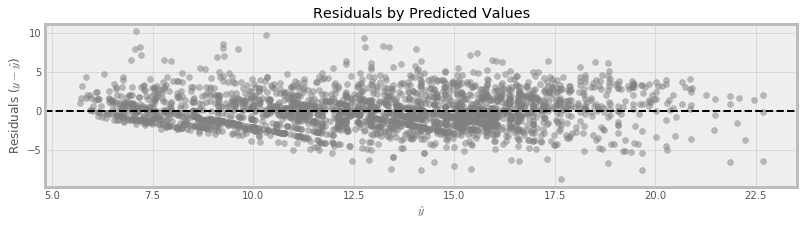

In [289]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")
    
def plot_many_residuals(var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = concrete[name]
        residual_plot(ax, x, concrete["compressive_strength"], y_hat)
        ax.set_xlabel(name)
        ax.set_title("Model Residuals by {}".format(name))
    return fig, axs

fig, ax = plt.subplots(figsize=(12, 3))
residual_plot(ax, predictions, df["interest_rate"], predictions)
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$")
plt.show()

In [291]:
r2 = r2_score(df['interest_rate'], predictions)
print("Our model is able to explain away roughly {0:.4f} percent of the variance in the response, using only the Amount Requested and the Fico Score".format(r2))

Our model is able to explain away roughly 0.6987 percent of the variance in the response, using only the Amount Requested and the Fico Score


As we can see above, the model fits the data relatively well considering its simplicity. With an $R^2$ of 0.6987, I'm relatively happy with the outcome; there doensn't seem to be any heteroscedasticity in the residuals. One observations is that, although subtle, there does seem to be a trend where my model tends to under predict interest rates on the low end.